<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/V1_continious_increment_apptom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d manjuphoenix/tomatodataset

 99% 917M/923M [00:05<00:00, 179MB/s]
100% 923M/923M [00:05<00:00, 167MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [23]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/Apple', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 1152
The number of images in a training set is: 36864
The number of images in a test set is: 7904
Dataset ImageFolder
    Number of datapoints: 26320
    Root location: /content/Apple
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust']


In [18]:
import torch
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path


# # To get the weights from the .pth file!
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v3_tomato.pk1'))
model.load_state_dict(checkpoint)

# # Preprocess any image before passing it to the model
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.CenterCrop(256),
#     transforms.RandomGrayscale(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomInvert(),
#     transforms.RandomRotation(30),
# ])


image = Image.open(Path('/content/gdrive/MyDrive/Tomato_dataset/tHealthy.JPG'))

# input = test_transform(image)

# input = input.view(1, 3, 256,256)

model = model.to(device)

# output = model(input)
# print(output)

# prediction = int(torch.max(output.data, 1)[1].numpy())
# print(prediction)

# if (prediction == 0):
#     print ('Bacterial_spot')
# if (prediction == 1):
#     print ('Early_blight')
# if (prediction == 2):
#     print ('Late_blight')
# if (prediction == 3):
#     print ('Septoria_leaf_spot')
# if (prediction == 4):
#     print ('Two-spotted_spider_mite')
# if (prediction == 5):
#     print ('Target_Spot')
# if (prediction == 6):
#     print ('Tomato_Yellow_Leaf_Curl_Virus')
# if (prediction == 7):
#     print ('Tomato___healthy')

In [20]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

[[2033   22   29  182   53    5   64  105]
 [  26 1792   65   39  106   35  262   21]
 [  97  175 1753   58   50   22  148   76]
 [ 266   30   34 1824   25   40  108   33]
 [   1    3    0    0 2466   57    1    1]
 [   4   16    0    6  137 2353    7    0]
 [ 142  309   65   68  100   44 1683    9]
 [  24   10    5   17   30    0    2 2343]]
[81.54833534 76.38533674 73.68642287 77.28813559 97.5088968  93.26198969
 69.54545455 96.3800905 ]


NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

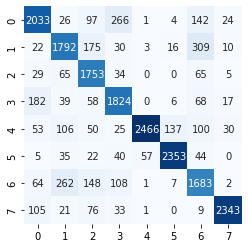

In [21]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
model.eval()

In [22]:
for param in model.parameters():
  param.requires_grad = False

model.fc2 = nn.Linear(1000,12)

In [25]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [26]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [27]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.0003, weight_decay=1e-5, momentum=0.6)

In [29]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=10
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 1152/1152 [00:41<00:00, 27.91it/s]


Train Loss: 0.821 | Accuracy: 69.542


100%|██████████| 247/247 [00:09<00:00, 26.58it/s]


Test Loss: 0.742 | Accuracy: 71.403

Epoch : 2


100%|██████████| 1152/1152 [00:40<00:00, 28.16it/s]


Train Loss: 0.704 | Accuracy: 72.861


100%|██████████| 247/247 [00:09<00:00, 25.64it/s]


Test Loss: 0.681 | Accuracy: 73.113

Epoch : 3


100%|██████████| 1152/1152 [00:40<00:00, 28.34it/s]


Train Loss: 0.659 | Accuracy: 73.863


100%|██████████| 247/247 [00:09<00:00, 27.07it/s]


Test Loss: 0.652 | Accuracy: 74.177

Epoch : 4


100%|██████████| 1152/1152 [00:41<00:00, 27.96it/s]


Train Loss: 0.627 | Accuracy: 75.022


100%|██████████| 247/247 [00:09<00:00, 26.35it/s]


Test Loss: 0.623 | Accuracy: 75.241

Epoch : 5


100%|██████████| 1152/1152 [00:40<00:00, 28.53it/s]


Train Loss: 0.609 | Accuracy: 75.760


100%|██████████| 247/247 [00:09<00:00, 26.43it/s]


Test Loss: 0.606 | Accuracy: 75.925

Epoch : 6


100%|██████████| 1152/1152 [00:40<00:00, 28.20it/s]


Train Loss: 0.596 | Accuracy: 76.316


100%|██████████| 247/247 [00:09<00:00, 27.08it/s]


Test Loss: 0.592 | Accuracy: 76.152

Epoch : 7


100%|██████████| 1152/1152 [00:40<00:00, 28.16it/s]


Train Loss: 0.585 | Accuracy: 76.848


100%|██████████| 247/247 [00:09<00:00, 26.75it/s]


Test Loss: 0.583 | Accuracy: 76.988

Epoch : 8


100%|██████████| 1152/1152 [00:40<00:00, 28.16it/s]


Train Loss: 0.574 | Accuracy: 77.358


100%|██████████| 247/247 [00:09<00:00, 26.73it/s]


Test Loss: 0.565 | Accuracy: 77.812

Epoch : 9


100%|██████████| 1152/1152 [00:40<00:00, 28.16it/s]


Train Loss: 0.566 | Accuracy: 77.537


100%|██████████| 247/247 [00:09<00:00, 26.54it/s]


Test Loss: 0.567 | Accuracy: 77.368

Epoch : 10


100%|██████████| 1152/1152 [00:40<00:00, 28.12it/s]


Train Loss: 0.562 | Accuracy: 77.860


100%|██████████| 247/247 [00:09<00:00, 26.73it/s]


Test Loss: 0.549 | Accuracy: 78.078

Epoch : 11


100%|██████████| 1152/1152 [00:41<00:00, 28.04it/s]


Train Loss: 0.548 | Accuracy: 78.346


100%|██████████| 247/247 [00:09<00:00, 26.36it/s]


Test Loss: 0.550 | Accuracy: 78.065

Epoch : 12


100%|██████████| 1152/1152 [00:40<00:00, 28.20it/s]


Train Loss: 0.539 | Accuracy: 78.808


100%|██████████| 247/247 [00:09<00:00, 26.29it/s]


Test Loss: 0.545 | Accuracy: 78.255

Epoch : 13


100%|██████████| 1152/1152 [00:40<00:00, 28.39it/s]


Train Loss: 0.544 | Accuracy: 78.832


100%|██████████| 247/247 [00:09<00:00, 26.43it/s]


Test Loss: 0.541 | Accuracy: 78.635

Epoch : 14


100%|██████████| 1152/1152 [00:40<00:00, 28.28it/s]


Train Loss: 0.532 | Accuracy: 79.122


100%|██████████| 247/247 [00:09<00:00, 26.33it/s]


Test Loss: 0.528 | Accuracy: 79.319

Epoch : 15


100%|██████████| 1152/1152 [00:40<00:00, 28.28it/s]


Train Loss: 0.525 | Accuracy: 79.532


100%|██████████| 247/247 [00:09<00:00, 26.87it/s]


Test Loss: 0.523 | Accuracy: 79.483

Epoch : 16


100%|██████████| 1152/1152 [00:41<00:00, 27.99it/s]


Train Loss: 0.520 | Accuracy: 79.847


100%|██████████| 247/247 [00:09<00:00, 26.66it/s]


Test Loss: 0.512 | Accuracy: 79.775

Epoch : 17


100%|██████████| 1152/1152 [00:40<00:00, 28.32it/s]


Train Loss: 0.516 | Accuracy: 80.069


100%|██████████| 247/247 [00:09<00:00, 27.07it/s]


Test Loss: 0.512 | Accuracy: 79.977

Epoch : 18


100%|██████████| 1152/1152 [00:40<00:00, 28.16it/s]


Train Loss: 0.508 | Accuracy: 80.352


100%|██████████| 247/247 [00:09<00:00, 26.23it/s]


Test Loss: 0.511 | Accuracy: 79.775

Epoch : 19


100%|██████████| 1152/1152 [00:41<00:00, 28.04it/s]


Train Loss: 0.500 | Accuracy: 80.903


100%|██████████| 247/247 [00:09<00:00, 26.98it/s]


Test Loss: 0.512 | Accuracy: 79.749

Epoch : 20


100%|██████████| 1152/1152 [00:40<00:00, 28.23it/s]


Train Loss: 0.503 | Accuracy: 80.550


100%|██████████| 247/247 [00:09<00:00, 26.58it/s]


Test Loss: 0.503 | Accuracy: 80.484

Epoch : 21


100%|██████████| 1152/1152 [00:40<00:00, 28.31it/s]


Train Loss: 0.498 | Accuracy: 80.846


100%|██████████| 247/247 [00:09<00:00, 26.11it/s]


Test Loss: 0.496 | Accuracy: 81.092

Epoch : 22


100%|██████████| 1152/1152 [00:40<00:00, 28.20it/s]


Train Loss: 0.497 | Accuracy: 80.743


100%|██████████| 247/247 [00:09<00:00, 26.40it/s]


Test Loss: 0.490 | Accuracy: 80.927

Epoch : 23


100%|██████████| 1152/1152 [00:41<00:00, 28.02it/s]


Train Loss: 0.488 | Accuracy: 81.698


100%|██████████| 247/247 [00:09<00:00, 25.82it/s]


Test Loss: 0.492 | Accuracy: 80.724

Epoch : 24


100%|██████████| 1152/1152 [00:41<00:00, 27.95it/s]


Train Loss: 0.492 | Accuracy: 80.938


100%|██████████| 247/247 [00:09<00:00, 26.80it/s]


Test Loss: 0.487 | Accuracy: 81.155

Epoch : 25


100%|██████████| 1152/1152 [00:41<00:00, 27.91it/s]


Train Loss: 0.485 | Accuracy: 81.429


100%|██████████| 247/247 [00:09<00:00, 26.68it/s]


Test Loss: 0.481 | Accuracy: 81.206

Epoch : 26


100%|██████████| 1152/1152 [00:41<00:00, 27.89it/s]


Train Loss: 0.482 | Accuracy: 81.407


100%|██████████| 247/247 [00:09<00:00, 26.67it/s]


Test Loss: 0.486 | Accuracy: 80.851

Epoch : 27


100%|██████████| 1152/1152 [00:40<00:00, 28.18it/s]


Train Loss: 0.481 | Accuracy: 81.676


100%|██████████| 247/247 [00:09<00:00, 26.45it/s]


Test Loss: 0.477 | Accuracy: 81.674

Epoch : 28


100%|██████████| 1152/1152 [00:41<00:00, 28.06it/s]


Train Loss: 0.473 | Accuracy: 82.146


100%|██████████| 247/247 [00:09<00:00, 26.80it/s]


Test Loss: 0.475 | Accuracy: 82.042

Epoch : 29


100%|██████████| 1152/1152 [00:40<00:00, 28.28it/s]


Train Loss: 0.471 | Accuracy: 81.994


100%|██████████| 247/247 [00:09<00:00, 26.72it/s]


Test Loss: 0.471 | Accuracy: 81.814

Epoch : 30


100%|██████████| 1152/1152 [00:41<00:00, 27.75it/s]


Train Loss: 0.463 | Accuracy: 82.620


100%|██████████| 247/247 [00:09<00:00, 26.63it/s]


Test Loss: 0.466 | Accuracy: 81.915

Epoch : 31


100%|██████████| 1152/1152 [00:41<00:00, 28.06it/s]


Train Loss: 0.465 | Accuracy: 82.289


100%|██████████| 247/247 [00:09<00:00, 27.01it/s]


Test Loss: 0.464 | Accuracy: 82.181

Epoch : 32


100%|██████████| 1152/1152 [00:41<00:00, 27.95it/s]


Train Loss: 0.458 | Accuracy: 82.962


100%|██████████| 247/247 [00:09<00:00, 25.52it/s]


Test Loss: 0.467 | Accuracy: 81.826

Epoch : 33


100%|██████████| 1152/1152 [00:40<00:00, 28.36it/s]


Train Loss: 0.462 | Accuracy: 82.498


100%|██████████| 247/247 [00:09<00:00, 26.75it/s]


Test Loss: 0.460 | Accuracy: 82.535

Epoch : 34


100%|██████████| 1152/1152 [00:41<00:00, 27.91it/s]


Train Loss: 0.451 | Accuracy: 83.242


100%|██████████| 247/247 [00:09<00:00, 26.62it/s]


Test Loss: 0.452 | Accuracy: 82.561

Epoch : 35


100%|██████████| 1152/1152 [00:41<00:00, 27.73it/s]


Train Loss: 0.456 | Accuracy: 82.933


100%|██████████| 247/247 [00:09<00:00, 26.27it/s]


Test Loss: 0.462 | Accuracy: 82.282

Epoch : 36


100%|██████████| 1152/1152 [00:40<00:00, 28.23it/s]


Train Loss: 0.453 | Accuracy: 82.718


100%|██████████| 247/247 [00:09<00:00, 26.64it/s]


Test Loss: 0.455 | Accuracy: 82.333

Epoch : 37


100%|██████████| 1152/1152 [00:41<00:00, 27.89it/s]


Train Loss: 0.452 | Accuracy: 83.356


100%|██████████| 247/247 [00:09<00:00, 27.00it/s]


Test Loss: 0.457 | Accuracy: 82.168

Epoch : 38


100%|██████████| 1152/1152 [00:41<00:00, 28.03it/s]


Train Loss: 0.449 | Accuracy: 83.334


100%|██████████| 247/247 [00:09<00:00, 26.41it/s]


Test Loss: 0.452 | Accuracy: 82.624

Epoch : 39


100%|██████████| 1152/1152 [00:40<00:00, 28.13it/s]


Train Loss: 0.454 | Accuracy: 83.006


100%|██████████| 247/247 [00:09<00:00, 26.22it/s]


Test Loss: 0.450 | Accuracy: 82.662

Epoch : 40


100%|██████████| 1152/1152 [00:41<00:00, 28.09it/s]


Train Loss: 0.448 | Accuracy: 83.226


100%|██████████| 247/247 [00:09<00:00, 26.40it/s]


Test Loss: 0.443 | Accuracy: 83.118

Epoch : 41


100%|██████████| 1152/1152 [00:40<00:00, 28.27it/s]


Train Loss: 0.443 | Accuracy: 83.505


100%|██████████| 247/247 [00:09<00:00, 26.57it/s]


Test Loss: 0.444 | Accuracy: 82.890

Epoch : 42


100%|██████████| 1152/1152 [00:41<00:00, 27.95it/s]


Train Loss: 0.438 | Accuracy: 83.744


100%|██████████| 247/247 [00:09<00:00, 27.04it/s]


Test Loss: 0.446 | Accuracy: 82.953

Epoch : 43


100%|██████████| 1152/1152 [00:41<00:00, 27.85it/s]


Train Loss: 0.434 | Accuracy: 83.749


100%|██████████| 247/247 [00:09<00:00, 26.48it/s]


Test Loss: 0.436 | Accuracy: 83.637

Epoch : 44


100%|██████████| 1152/1152 [00:41<00:00, 27.84it/s]


Train Loss: 0.440 | Accuracy: 83.345


100%|██████████| 247/247 [00:09<00:00, 26.29it/s]


Test Loss: 0.445 | Accuracy: 83.080

Epoch : 45


100%|██████████| 1152/1152 [00:40<00:00, 28.26it/s]


Train Loss: 0.438 | Accuracy: 83.627


100%|██████████| 247/247 [00:09<00:00, 26.63it/s]


Test Loss: 0.441 | Accuracy: 82.865

Epoch : 46


100%|██████████| 1152/1152 [00:40<00:00, 28.11it/s]


Train Loss: 0.433 | Accuracy: 83.977


100%|██████████| 247/247 [00:09<00:00, 26.21it/s]


Test Loss: 0.440 | Accuracy: 82.928

Epoch : 47


100%|██████████| 1152/1152 [00:41<00:00, 27.99it/s]


Train Loss: 0.434 | Accuracy: 83.595


100%|██████████| 247/247 [00:09<00:00, 26.38it/s]


Test Loss: 0.433 | Accuracy: 83.688

Epoch : 48


100%|██████████| 1152/1152 [00:41<00:00, 28.04it/s]


Train Loss: 0.424 | Accuracy: 84.368


100%|██████████| 247/247 [00:09<00:00, 26.82it/s]


Test Loss: 0.435 | Accuracy: 83.650

Epoch : 49


100%|██████████| 1152/1152 [00:41<00:00, 27.97it/s]


Train Loss: 0.426 | Accuracy: 84.138


100%|██████████| 247/247 [00:09<00:00, 26.69it/s]


Test Loss: 0.434 | Accuracy: 83.612

Epoch : 50


100%|██████████| 1152/1152 [00:41<00:00, 28.07it/s]


Train Loss: 0.429 | Accuracy: 83.942


100%|██████████| 247/247 [00:09<00:00, 26.27it/s]


Test Loss: 0.434 | Accuracy: 83.726

Epoch : 51


100%|██████████| 1152/1152 [00:41<00:00, 27.85it/s]


Train Loss: 0.425 | Accuracy: 84.146


100%|██████████| 247/247 [00:09<00:00, 26.37it/s]


Test Loss: 0.428 | Accuracy: 84.309

Epoch : 52


100%|██████████| 1152/1152 [00:41<00:00, 27.95it/s]


Train Loss: 0.419 | Accuracy: 84.428


100%|██████████| 247/247 [00:09<00:00, 26.57it/s]


Test Loss: 0.428 | Accuracy: 83.663

Epoch : 53


100%|██████████| 1152/1152 [00:41<00:00, 27.70it/s]


Train Loss: 0.418 | Accuracy: 84.482


100%|██████████| 247/247 [00:09<00:00, 26.35it/s]


Test Loss: 0.426 | Accuracy: 83.688

Epoch : 54


100%|██████████| 1152/1152 [00:41<00:00, 27.89it/s]


Train Loss: 0.424 | Accuracy: 84.485


100%|██████████| 247/247 [00:09<00:00, 26.96it/s]


Test Loss: 0.422 | Accuracy: 84.169

Epoch : 55


100%|██████████| 1152/1152 [00:41<00:00, 27.94it/s]


Train Loss: 0.419 | Accuracy: 84.401


100%|██████████| 247/247 [00:09<00:00, 26.36it/s]


Test Loss: 0.421 | Accuracy: 84.321

Epoch : 56


100%|██████████| 1152/1152 [00:41<00:00, 27.63it/s]


Train Loss: 0.419 | Accuracy: 84.667


100%|██████████| 247/247 [00:09<00:00, 26.70it/s]


Test Loss: 0.419 | Accuracy: 84.220

Epoch : 57


100%|██████████| 1152/1152 [00:41<00:00, 28.04it/s]


Train Loss: 0.426 | Accuracy: 84.235


100%|██████████| 247/247 [00:09<00:00, 25.93it/s]


Test Loss: 0.416 | Accuracy: 84.448

Epoch : 58


100%|██████████| 1152/1152 [00:41<00:00, 27.93it/s]


Train Loss: 0.418 | Accuracy: 84.292


100%|██████████| 247/247 [00:09<00:00, 26.38it/s]


Test Loss: 0.422 | Accuracy: 84.334

Epoch : 59


100%|██████████| 1152/1152 [00:41<00:00, 27.80it/s]


Train Loss: 0.413 | Accuracy: 84.775


100%|██████████| 247/247 [00:09<00:00, 26.81it/s]


Test Loss: 0.411 | Accuracy: 84.321

Epoch : 60


100%|██████████| 1152/1152 [00:41<00:00, 27.47it/s]


Train Loss: 0.414 | Accuracy: 84.754


100%|██████████| 247/247 [00:09<00:00, 26.91it/s]

Test Loss: 0.411 | Accuracy: 84.739


[[1852   52   40   28]
 [ 114 1421  289  158]
 [  87  285 1592    5]
 [  96   82    1 1794]]
[93.9148073  71.69525732 80.85322499 90.92752154]


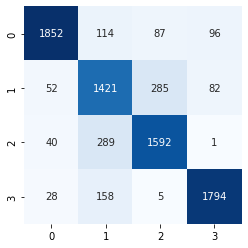

In [30]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

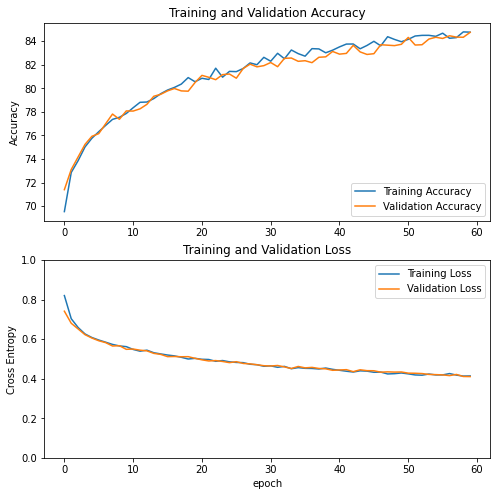

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         self.cnn3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu3 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
#         out = self.cnn3(out)
#         out = self.relu3(out)
#         out = self.maxpool3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0003
optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [ ]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [ ]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.6)

In [ ]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=60
for epoch in range(1,int(epochs)+1):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  

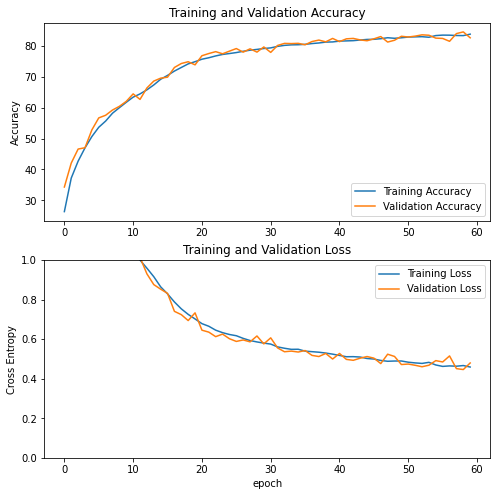

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
#Testing classification accuracy for individual classes.
classes = ['Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: ignored

In [ ]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  82.44007240801498


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v3_tomato.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v3_tomato_scripted.pt') # Save

In [ ]:
train_path = "/content/Tomato"
train_list = os.listdir(train_path)
print(len(train_list))

8


[[2069   33   26  167   48    0   56   94]
 [  33 1780   62   40  123   30  256   22]
 [ 114  181 1726   51   50   29  162   66]
 [ 242   25   35 1846   25   42  108   37]
 [   1    3    1    0 2460   62    1    1]
 [   1   13    0    7  154 2343    4    1]
 [ 153  312   71   74   90   49 1666    5]
 [  18    7    7   15   28    0    1 2355]]
[82.99237866 75.87382779 72.55149222 78.22033898 97.27164887 92.86563615
 68.84297521 96.87371452]


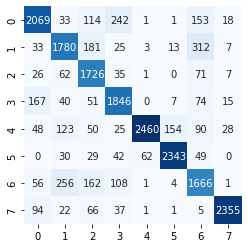

In [19]:
from sklearn.metrics import confusion_matrix

nb_classes = 8

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
model.cnn2 = nn.Linear(1024,10)
model.to(device)

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/CornModelV1.pk1')

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('CornModelV1.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelV1.pk1')